In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline

In [106]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [107]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [108]:
team_1 = 'Kolkata Knight Riders'
team_2 = 'Royal Challengers Bangalore'


# Winning Probability of Teams

Text(0.5, 1.0, 'RCB Total Runs Score Stats')

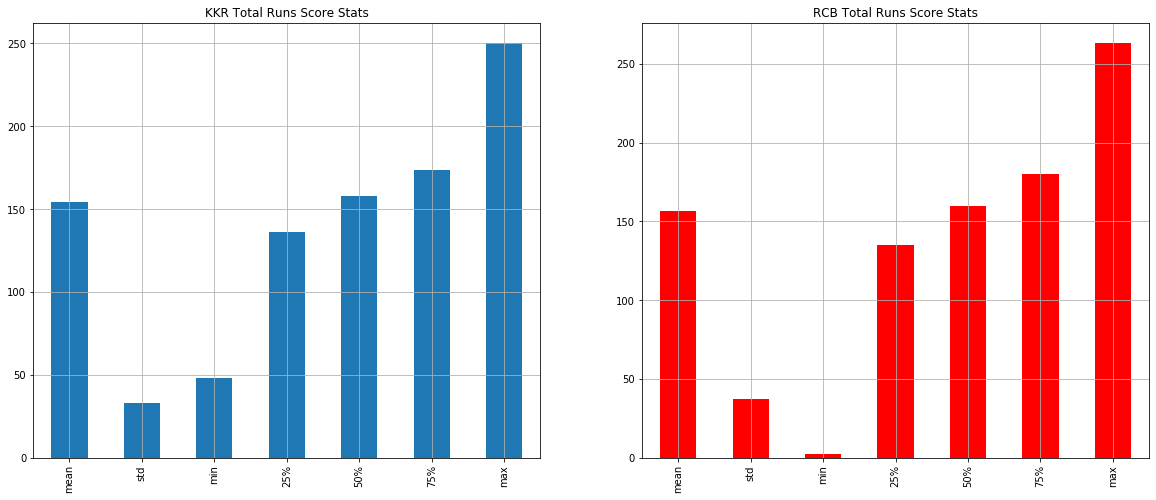

In [109]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs'].describe()[1:].plot(ax=ax[0], kind='bar', grid=True)
delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs'].describe()[1:].plot(ax=ax[1], kind='bar', color='red', grid=True)
ax[0].set_title("KKR Total Runs Score Stats")
ax[1].set_title("RCB Total Runs Score Stats")

Text(0.5, 1.0, 'Percentage of Winning')

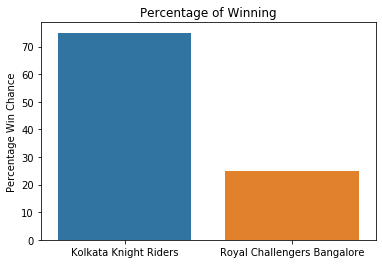

In [110]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
sns.barplot(wins.index, y=wins['Percentage Win Chance'])
plt.title('Percentage of Winning')

In [111]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

# RCB wickets fall in 6 to 20 overs

Text(0.5, 1.0, 'RCB wickets fall stats in powerplay against KKR')

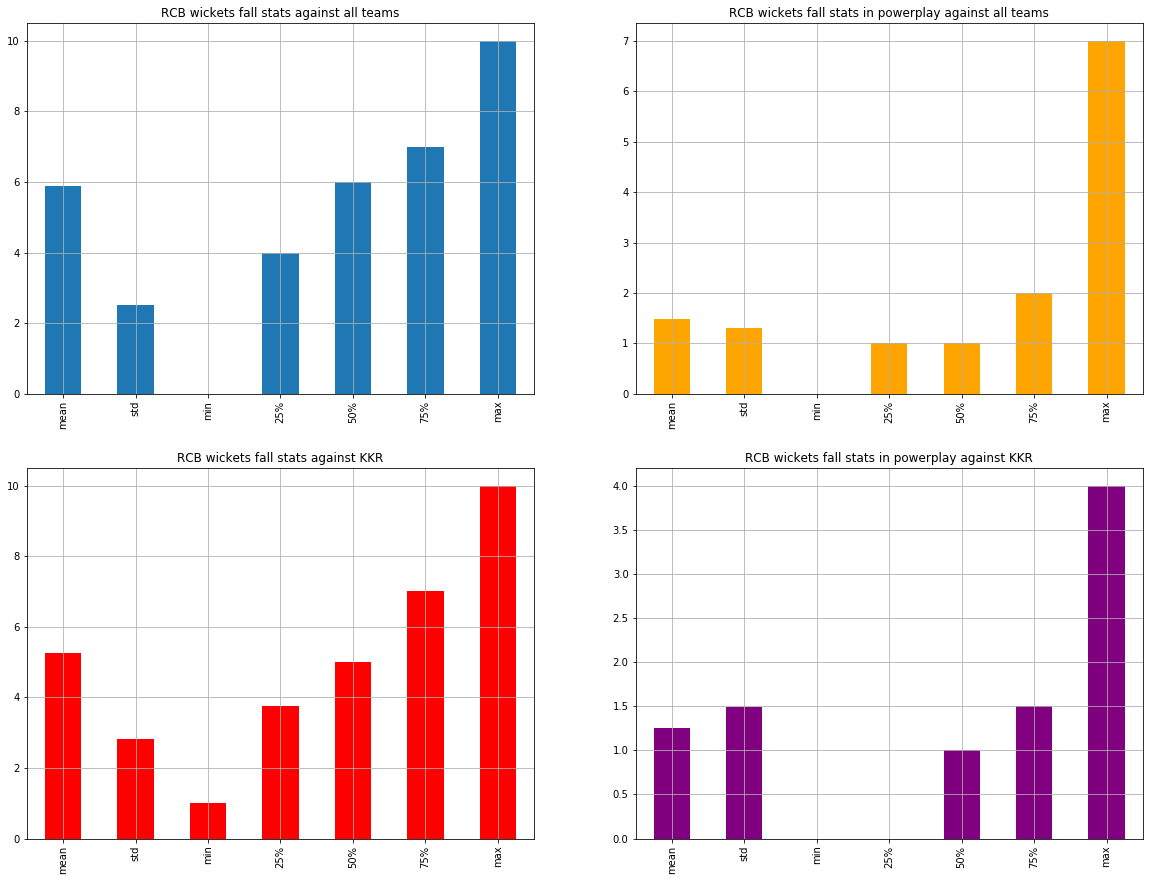

In [112]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
delivery[(delivery['batting_team']==team_2)].groupby('match_id').sum()['player_dismissed'].describe()[1:].plot(ax=ax[0,0],kind='bar', grid=True)
delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].describe()[1:].plot(ax=ax[0,1],kind='bar', grid=True, color='orange')
delivery[(delivery['batting_team']==team_2) &(delivery['bowling_team']==team_1)].groupby('match_id').sum()['player_dismissed'].describe()[1:].plot(ax=ax[1,0],kind='bar', grid=True, color='red')
delivery[(delivery['batting_team']==team_2) &(delivery['bowling_team']==team_1) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].describe()[1:].plot(ax=ax[1,1],kind='bar', grid=True, color='purple')
ax[0, 0].set_title('RCB wickets fall stats against all teams')
ax[0, 1].set_title('RCB wickets fall stats in powerplay against all teams')
ax[1, 0].set_title('RCB wickets fall stats against KKR')
ax[1, 1].set_title('RCB wickets fall stats in powerplay against KKR')

These graphs suggests that :

- RCB will loose generally around 4 to 5 wickets
- There is a probability that 1 wicket will fall during RCB powerplay.

So, they will loose around 4 wickets between 31st ball and 120th ball

# Balls required to hit 30 runs by AB de Villiers 

In [113]:
ab_balls = list()
ab_match_id = list()
for match_id in delivery[(delivery['batsman']=='AB de Villiers')]['match_id'].unique():
    runs = 0
    balls = 0
    for run in delivery[(delivery['batsman']=='AB de Villiers') & (delivery['match_id']==match_id)]['batsman_runs']:
        runs += run
        balls += 1
        if runs in range(30, 36):
            ab_balls.append(balls)
            ab_match_id.append(match_id)
            break
        
ab_30 = pd.DataFrame(index=ab_match_id, data=ab_balls, columns=['Balls to Score 30'])

In [114]:
ab = delivery[(delivery['batsman']=='AB de Villiers')]
strike_rate = list()
match_ids_ = list()
balls_faced = list()
bat_runs = list()
for match_id in ab.match_id.unique():
    balls = 0
    runs = 0
    
    for run in ab[ab['match_id']==match_id]['batsman_runs']:
        balls += 1 
        runs += run
        if runs in range(30, 36):
            break       

    balls_faced.append(balls)
    bat_runs.append(runs)
    match_ids_.append(match_id)    
    strike_rate.append(runs*100/balls)
        
ab_sr = pd.DataFrame(index=match_ids_, data={'Strike Rate':strike_rate, 'Runs Scored':bat_runs,'Balls Played': balls_faced})
ab_sr.describe()

,Strike Rate,Runs Scored,Balls Played
count,49.000000,49.000000,49.000000
mean,123.980388,20.367347,15.306122
std,60.429204,12.567640,8.314656
min,0.000000,0.000000,2.000000
25%,86.363636,8.000000,8.000000
50%,126.923077,26.000000,16.000000
75%,157.894737,32.000000,22.000000
max,275.000000,35.000000,32.000000


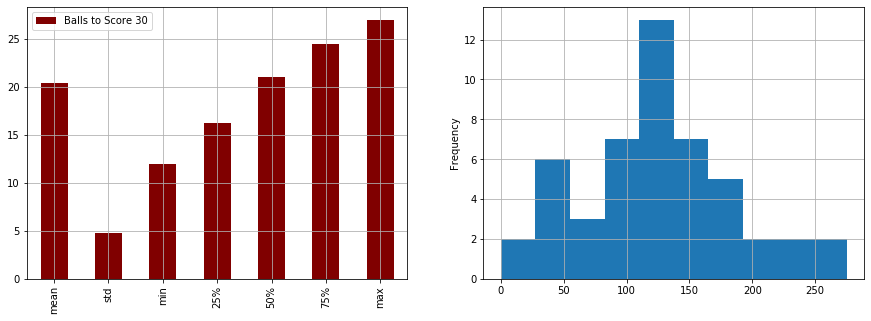

In [115]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ab_30.describe()[1:].plot(ax=ax[0], kind='bar', color='maroon', grid=True)
ab_sr['Strike Rate'].plot(ax=ax[1], kind='hist', grid=True)

The strike rate graph and central tendency measures graph suggests that AB will take around 18 to 24 balls to score 30 runs. 

# Morgan Strike Rate Difference

In [116]:
morgan = delivery[(delivery['batsman']=='EJG Morgan')]
strike_rate_m = list()
match_ids_m = list()
balls_faced_m = list()
bat_runs_m = list()
last_sr = list()
for match_id in morgan.match_id.unique():
    balls = 0
    runs = 0
    last = 0
    for run in morgan[morgan['match_id']==match_id]['batsman_runs']:
        balls += 1 
        runs += run    
    for run in morgan[morgan['match_id']==match_id]['batsman_runs'][-7:]:
        last += run
        
    balls_faced_m.append(balls)
    bat_runs_m.append(runs)
    match_ids_m.append(match_id)    
    strike_rate_m.append(runs*100/balls)
    last_sr.append(last*100/7)
        
morgan_sr = pd.DataFrame(index=match_ids_m, data={'Runs Scored':bat_runs_m,'Balls Played': balls_faced_m,'Strike Rate':strike_rate_m, "Strike Rate in last 7 balls":last_sr})
morgan_sr['SR Difference'] = abs(morgan_sr['Strike Rate']-morgan_sr['Strike Rate in last 7 balls'])
morgan_sr.head()

,Runs Scored,Balls Played,Strike Rate,Strike Rate in last 7 balls,SR Difference
15,22,20,110.000000,157.142857,47.142857
19,13,17,76.470588,28.571429,47.899160
32,26,21,123.809524,142.857143,19.047619
54,4,4,100.000000,57.142857,42.857143
580,22,18,122.222222,100.000000,22.222222


In [117]:
morgan_sr['SR Difference'].describe()

count    10.000000
mean     37.532625
std      30.306509
min       0.000000
25%      17.619048
50%      32.539683
75%      47.710084
max      95.681063
Name: SR Difference, dtype: float64

Text(0.5, 1.0, 'Morgan Strike in last 7 balls Rate Frequency')

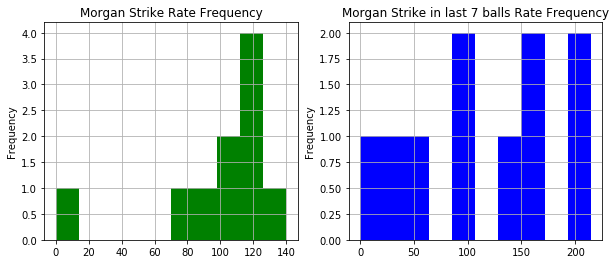

In [118]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
morgan_sr['Strike Rate'].plot(ax=ax[0], kind='hist', grid=True, color='green')
morgan_sr['Strike Rate in last 7 balls'].plot(ax=ax[1], kind='hist', grid=True, color='blue')
ax[0].set_title("Morgan Strike Rate Frequency")
ax[1].set_title("Morgan Strike in last 7 balls Rate Frequency")

The central tendency measure values and the graph suggests that differnce will be less than 75.


# RCB runs made in death overs against KKR

Text(0.5, 1.0, 'Runs scored by RCB in death overs against KKR')

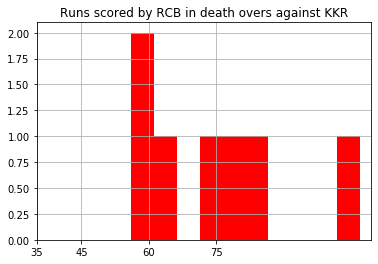

In [119]:
delivery[(delivery['batting_team']==team_2) & (delivery['bowling_team']==team_1) & (delivery['over']>=15)].groupby('match_id').sum()['total_runs'].hist(color='red')
plt.xticks([35, 45, 60, 75])
plt.title("Runs scored by RCB in death overs against KKR")

Text(0.5, 1.0, 'Runs scored by RCB in death overs against all teams')

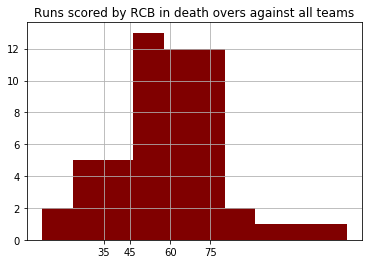

In [120]:
delivery[(delivery['batting_team']==team_2) & (delivery['over']>=15)].groupby('match_id').sum()['total_runs'].hist(color='maroon')
plt.xticks([35, 45, 60, 75])
plt.title("Runs scored by RCB in death overs against all teams")

Both the plot suggests that RCb will score around 46-60 runs in death overs

# Summary

- Using mean and median values the total score per match by teams was compared and using winner column the chances of winning were calculated. 
- Using RCB wickets fall in the powerplay and normal overs against all teams and KKR separately, the estimation of wickets fall was taken. 
- AB's strike rate was calculated for first 30 runs and also the number of balls for AB to score 30 runs per match was taken, which suggested that mean number of balls and calculation of balls using strike rate falls under same range. 
- Morgan strike rate overall per match and for the last 7 balls he played was taken. Using both types of strike rate, histograms were plotted and also, the average difference between strike was considered. Combining the results together the range was estimated. 
- RCB scores against KKR and against all teams during death over was calculated and using histograms and mean values the range of runs to be hit was predicted. 